#  Hierarchical nucleation of deep networks

### Import libraries and data

In [2]:
# Compile the cython extension locally

!python setup_cython.py build_ext -b src/ ;


running build_ext


In [3]:
# Import libraries and source code to run the analysis
import sys
sys.path.insert(0,'src/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pathlib
from matplotlib.gridspec import GridSpec
from sklearn.metrics.cluster import adjusted_rand_score
from utils import Data_sets, kernel_PCA
import requests
import tarfile

%load_ext autoreload
%autoreload 2


In [4]:
url = 'https://figshare.com/ndownloader/files/45441850'
tarpath = './data/dist_imagenet90k_r152.tar.gz'
if not os.path.isdir("data/maxk_30"):
    pathlib.Path('data').mkdir(parents=True, exist_ok=True)
    response = requests.get(url)
    with open(tarpath, 'wb') as f:
        f.write(response.content)
    
    with tarfile.open(tarpath, 'r:gz') as tar:
        tar.extractall('./data')

In [5]:
# Ids of the 90000 images used, class label assignements and macro label assignments
folder = 'samples_ids_and_macrolabels/'

sampled_images_id = np.loadtxt(folder + 'sampled_images_id.txt', dtype='str')
macro_labels = np.genfromtxt(folder + 'macro_labels.txt')
class_labels = np.repeat(np.arange(300), 300)


In [6]:
# Initialise a "Data_sets" class containing the distance matrices for the selected layers 

data_folder = './data/maxk_30'

checkpoints = np.array([0, 1, 10, 34, 97, 142, 145, 148, 151, 152, 153])

ds = Data_sets()

for cp in checkpoints:
    distances = np.load(data_folder + '/layer_{}.npz'.format(cp))
    ds.add_one_dataset(distances=(distances['dist'], distances['index']), labels = class_labels, maxk = 30)

### Evolution of the neighborhood composition in ResNet152 (section 3.1)

In [ ]:
# overlap with ground truth labels
overlap_gt = np.array(ds.return_label_overlap_mean())

# overlap with output layer
print('Computing overlap with output layer')
overlap_output = np.array([ds.return_overlap_mean_btw_layers(i, -1, k=30) for i in range(len(checkpoints))])

computing overlap for dataset 0/11
computing overlap for dataset 1/11
computing overlap for dataset 2/11
computing overlap for dataset 3/11
computing overlap for dataset 4/11
computing overlap for dataset 5/11
computing overlap for dataset 6/11



* Here we plot the overlap with the ground truth labels for the checkpoints discussed in section 2.3, i.e. the layers [0,1,10,34,142,151,152,153]. The plot on the left is part of Fig. 2-a. On the right we show the overlaps as a function of the layer depths


<ipython-input-10-9088dbf7cff8>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs1.tight_layout(fig, rect = [0.5, 0, 1,1])


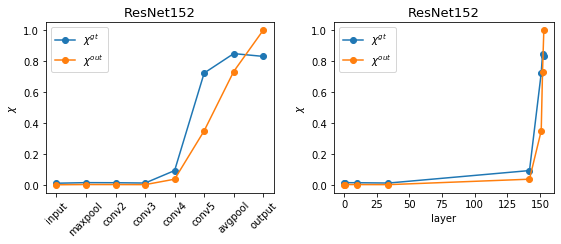

In [10]:

layer_label = ['input', 'maxpool', 'conv2', 'conv3', 'conv4', 'conv5', 'avgpool', 'output']
cpt = np.array([0,1,2,3,5,8,9,10])
fig = plt.figure(figsize= (8, 3.5))

gs0 = GridSpec(1, 1)
ax0 = fig.add_subplot(gs0[0])
ax0.plot(np.arange(8), overlap_gt[cpt], label = r'$\chi^{gt}$', marker = 'o')
ax0.plot(np.arange(8), overlap_output[cpt], label = r'$\chi^{out}$', marker = 'o')
ax0.set_xticks(np.arange(8))
ax0.set_xticklabels(layer_label, rotation = 45)
ax0.set_title('ResNet152', fontsize = 13)
ax0.legend()
ax0.set_ylabel(r'$\chi$')
gs0.tight_layout(fig, rect = [0, 0, 0.5,1])

gs1 = GridSpec(1, 1)
ax1 = fig.add_subplot(gs1[0])
ax1.plot(checkpoints[cpt], overlap_gt[cpt], label = r'$\chi^{gt}$', marker = 'o')
ax1.plot(checkpoints[cpt], overlap_output[cpt], label = r'$\chi^{out}$', marker = 'o')
ax1.set_title('ResNet152', fontsize = 13)
ax1.legend()
ax1.set_ylabel(r'$\chi$')
ax1.set_xlabel('layer')
gs1.tight_layout(fig, rect = [0.5, 0, 1,1])

bottom = max(gs1.bottom, gs0.bottom)
top = min(gs1.top, gs0.top)
gs0.update(top = top, bottom = bottom)
gs1.update(top = top, bottom = bottom)

### Evolution of the intrinsic dimension (Appendix A.5)

In [11]:
### Compute intrisic dimension across all layers 
ds.compute_id(fraction = 0.95, decimation = 1)

computing id of layer  0
computing id of layer  1
computing id of layer  2
computing id of layer  3
computing id of layer  4
computing id of layer  5
computing id of layer  6
computing id of layer  7
computing id of layer  8
computing id of layer  9
computing id of layer  10


<ipython-input-12-40bc4ee96c3e>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(gs0[0])


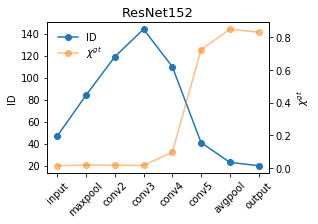

In [12]:
### Here we plot the intrisic dimesion profile of ResNet152 shown in figure A.4; also in this case 
### we only the layers analysed in the paper : l = [0, 1, 10, 34, 142, 151, 152, 153]

layer_label = ['input', 'maxpool', 'conv2', 'conv3', 'conv4', 'conv5', 'avgpool', 'output']
cpt = np.array([0,1,2,3,5,8,9,10])
fig = plt.figure(figsize= (4, 3))

gs0 = GridSpec(1, 1)

ax1 = fig.add_subplot(gs0[0])
ax1.plot(np.arange(8), np.array(ds.ids)[cpt], label = 'ID', marker = 'o', color = 'C0')
ax1.set_ylabel('ID')
ax1.set_xticks(np.arange(8))
ax1.set_xticklabels(layer_label, rotation = 45)
gs0.tight_layout(fig, rect = [0, 0, 1,1])

ax2 = fig.add_subplot(gs0[0])
ax2 = ax1.twinx()
ax2.plot(np.arange(8), overlap_gt[cpt], label = r'$\chi^{gt}$', marker = 'o', color = 'C1', alpha = 0.5)
ax2.set_title('ResNet152', fontsize = 13)
#ax2.legend()
ax2.set_ylabel(r'$\chi^{gt}$')

ax1.legend(loc = (.03, .84), frameon = False)
ax2.legend(loc = (.03, .72), frameon = False)

#plt.plot(np.arange(8), np.array(ds.ids)[cpt], '-o')
#plt.xlabel('layer')
#plt.ylabel('ID')

### Evolution of the data probability distribution across the hidden layers (Section 3.3)

* Density estimation

In [13]:
### Compute density of each point across all layers ###
ds.compute_density_kNN(k= 30)

computing kNN density for dataset  0
computing kNN density for dataset  1
computing kNN density for dataset  2
computing kNN density for dataset  3
computing kNN density for dataset  4
computing kNN density for dataset  5
computing kNN density for dataset  6
computing kNN density for dataset  7
computing kNN density for dataset  8
computing kNN density for dataset  9
computing kNN density for dataset  10


* Topography of the density landscape (peaks and saddle points)

In [14]:
### Find density peaks and saddle points between them for all layers ###
ds.compute_clustering(Z = 1.65, halo = False)

Z = 1.65, halo = False
computing clustering for dataset  0
computing clustering for dataset  1
computing clustering for dataset  2
computing clustering for dataset  3
computing clustering for dataset  4
computing clustering for dataset  5
computing clustering for dataset  6
computing clustering for dataset  7
computing clustering for dataset  8
computing clustering for dataset  9
computing clustering for dataset  10
Z = 1.65, halo = False


In [15]:
### Save density peaks and saddle points ###

folder = './data/peaks_and_saddle_points'

if not os.path.isdir(f'{folder}'):
                pathlib.Path(f'{folder}').mkdir(parents=True, exist_ok=True)

for layer, cp in zip(ds.data_sets, checkpoints):
    
    #peaks = [layer.Rho[j] for j in layer.centers_m]
    topography_matrix = layer.out_bord
    with open(f'{folder}/layer_{cp}_topography.txt', 'w') as f:
        for i in range(len(topography_matrix)):
            for j in range(len(topography_matrix[i])):
                f.write(f'{topography_matrix[i, j]} ')
            f.write('\n')
    with open(f'{folder}/layer_{cp}_densities.txt', 'w') as f:
        for i in range(len(layer.Rho)):
            f.write(f'{layer.Rho[i]} \n')

* Adjusted Rand index (figure 4-b) (the profiles don't match exactly those of fig 4-b since we use a subset of the layers analysed in the paper)

In [16]:
### Compute Adjusted Rand Index between density peaks and classes or macro-classes (animals, artifacts, ...)

ARIs_classes = []
ARIs_macro = []

for layer in ds.data_sets:
    ARI = adjusted_rand_score(layer.labels, class_labels)
    ARIs_classes.append(ARI)
    
    ARI = adjusted_rand_score(layer.labels, macro_labels)
    ARIs_macro.append(ARI)

Text(0, 0.5, 'ARI')

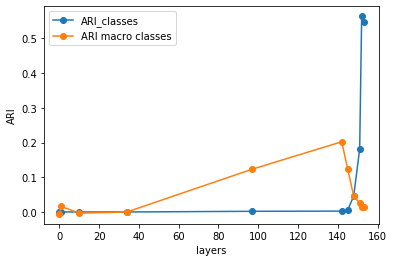

In [17]:
plt.plot(checkpoints, ARIs_classes, '-o', label = 'ARI_classes')
plt.plot(checkpoints, ARIs_macro, '-o', label = 'ARI macro classes')
plt.legend()
plt.xlabel('layers')
plt.ylabel('ARI')

* Two dimensional visualization of the peaks (panels in figure 4-a)

In [18]:
### Plot 2D representation of the density peaks of a given layer

# select a specific layer
layer = ds.data_sets[-1]

# compute 2D embedding
embedding = kernel_PCA(layer)

# Size of density peaks
s = []
for i in range(layer.Nclus_m):
    s.append(3. * np.sqrt(len(layer.clstruct_m[i])))

# Color of density peaks (proportion of animals or artifacts)
col = []
for i in range(layer.Nclus_m):
    idx = layer.clstruct_m[i]
    ancs = macro_labels[idx]
    n_animals = sum(ancs == 13)
    n_artifacts = sum(ancs == 2)

    an_frac = n_animals/(n_animals + n_artifacts) 
    
    # subtract baseline ratio between the two (unbalanced) macro classes
    an_frac = an_frac - (38400/(47100 + 38400)) + 0.5 
    
    col.append(cm.coolwarm(an_frac))
    

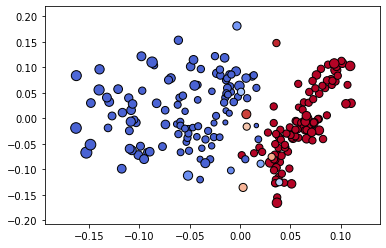

In [19]:
plt.scatter(embedding[:, 0], embedding[:, 1], s = s, c = col, edgecolor = 'k')